In [1]:
%config InlineBackend.figure_format = "retina"

In [31]:
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from helpers import smooth_model_outputs, subsample_train

from matplotlib import gridspec
from sklearn.utils.class_weight import compute_sample_weight
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from automated_scoring.classification import (
    plot_classification_timeline,
    plot_confusion_matrix,
    predict,
)
from automated_scoring.config import cfg
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.io import from_yaml, load_dataset, save_dataset
from automated_scoring.utils import Experiment

from observation_library.utils import adjust_lightness

In [3]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = ("keypoints", "timestamps")

In [5]:
# load training and test datasets
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)
dataset_test = load_dataset(
    "mice_test",
    directory="../../datasets/CALMS21/test",
    target="dyad",
    background_category="none",
)

# initialize a feature extractor from a configuration file
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("config_file.yaml")

# set a fixed random state for reproducible results
random_state = np.random.default_rng(1)

# subsample dataset and encode target from string to numeric
X, y = subsample_train(
    dataset_train.exclude_individuals(["intruder"]),
    extractor,
    random_state=random_state,
    log=None,
)
y = dataset_train.encode(y)

# specify and fit classification model
classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(
    X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
)

# use model for predictions on the test dataset
test_result = predict(
    dataset_test.exclude_individuals(["intruder"]),
    classifier,
    extractor,
    log=None,
)

best_parameters = from_yaml("optimization-summary.yaml")
best_thresholds = [best_parameters[f"threshold-{category}"] for category in test_result.categories]

# save the classification result as a dataset
# additionally, apply a smoothing filter and custom decision thresholds

save_dataset(
    test_result.smooth(partial(smooth_model_outputs, best_parameters), decision_thresholds=best_thresholds).to_dataset(
        trajectories={identifier: group.trajectories for identifier, group in dataset_test},
        background_category="none",
    ),
    directory="../../datasets/CALMS21/pred",
    dataset_name="mice_pred",
    observation_suffix="predictions",
)

2025-03-04 17:44:45.873 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
2025-03-04 17:44:46.618 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [8]:
def summarize_scores(result, *, foreground_categories, run, postprocessing_step):
    scores = test_result.score()
    summary = scores.stack().reset_index()
    summary = pd.DataFrame(
        np.array(summary[0]),
        index=summary["level_0"] + "_f1" + "-" + summary["level_1"],
    ).T
    columns = summary.columns
    summary["run"] = run
    summary["postprocessing_step"] = postprocessing_step
    summary = summary[["run", "postprocessing_step", *columns]]
    for level in scores.index:
        summary[f"{level}_f1-macro-foreground"] = scores.loc[level, list(foreground_categories)].mean()
        summary[f"{level}_f1-macro-all"] = scores.loc[level].mean()
    summary.columns = pd.MultiIndex.from_tuples(
        [(column.split("-", 1) if "-" in column else (column, "")) for column in summary.columns]
    )
    return summary

In [76]:
experiment = Experiment(20, random_state=1)

for run in tqdm(experiment, total=experiment.num_runs):
    X, y = subsample_train(
        dataset_train.exclude_individuals(["intruder"]),
        extractor,
        random_state=experiment.random_state,
        log=None,
    )
    y = dataset_train.encode(y)

    classifier = XGBClassifier(n_estimators=1000, random_state=experiment.random_state).fit(
        X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
    )

    summary = []
    y = {"true": {}, "pred": {}}

    test_result = predict(dataset_test.exclude_individuals(["intruder"]), classifier, extractor, log=None)
    summary.append(
        summarize_scores(
            test_result,
            foreground_categories=dataset_test.foreground_categories,
            run=run,
            postprocessing_step="model_outputs",
        )
    )

    test_result = test_result.smooth(partial(smooth_model_outputs, best_parameters))
    summary.append(
        summarize_scores(
            test_result,
            foreground_categories=dataset_test.foreground_categories,
            run=run,
            postprocessing_step="smoothed",
        )
    )

    test_result = test_result.threshold(best_thresholds, default_decision="none")
    summary.append(
        summarize_scores(
            test_result,
            foreground_categories=dataset_test.foreground_categories,
            run=run,
            postprocessing_step="thresholded",
        )
    )

    summary = pd.concat(summary, ignore_index=True)

    y["true"]["timestamp"] = test_result.y_true_numeric
    y["pred"]["timestamp"] = test_result.y_pred_numeric
    y["true"]["annotation"] = dataset_test.encode(test_result.annotations["category"].to_numpy())
    y["pred"]["annotation"] = dataset_test.encode(test_result.annotations["predicted_category"].to_numpy())
    y["true"]["prediction"] = dataset_test.encode(test_result.predictions["true_category"].to_numpy())
    y["pred"]["prediction"] = dataset_test.encode(test_result.predictions["category"].to_numpy())

    experiment.add((summary, y))

  0%|          | 0/20 [00:00<?, ?it/s]

In [80]:
summary = pd.concat([summary for summary, _ in experiment.collect().values()], ignore_index=True)
confusion = [y for _, y in experiment.collect().values()]

summary.head()

run postprocessing_step timestamp_f1                                    \
                                attack investigation     mount      none   
0   0       model_outputs     0.639062      0.807395  0.899919  0.950017   
1   0            smoothed     0.767798      0.819674  0.895821  0.946627   
2   0         thresholded     0.761257      0.836924  0.915997  0.945042   
3   1       model_outputs     0.634327      0.809845  0.901307  0.951128   
4   1            smoothed     0.755884      0.820273  0.897600  0.947518   

  annotation_f1                                   prediction_f1                \
         attack investigation     mount      none        attack investigation   
0      0.620429      0.749453  0.859729  0.865288      0.375451      0.554899   
1      0.557908      0.548903  0.651163  0.746479      0.835821      0.866873   
2      0.550206      0.724018  0.770781  0.787420      0.804979      0.848175   
3      0.610086      0.741561  0.860412  0.867967      0.372974      0.554092   
4      0.546354      0.545994  0.643545  0.749320      0.818182      0.871102   

                          timestamp_f1              annotation_f1            \
      mount      none macro-foreground macro-all macro-foreground macro-all   
0  0.393500  0.597032         0.782126  0.824098         0.743203  0.773725   
1  0.912621  0.937190         0.827765  0.857480         0.585991  0.626113   
2  0.877888  0.898611         0.838060  0.864805         0.681668  0.708106   
3  0.401387  0.587911         0.781827  0.824152         0.737353  0.770006   
4  0.925566  0.941079         0.824586  0.855319         0.578631  0.621303   

     prediction_f1            
  macro-foreground macro-all  
0         0.441283  0.480221  
1         0.871772  0.888126  
2         0.843681  0.857413  
3         0.442818  0.479091  
4         0.871617  0.888982

In [252]:
def aggregate_scores(summary, score_level, *, categories):
    return (
        summary.loc[:, ["postprocessing_step", score_level]]
        .sort_index(axis=1)  # avoid unsorted index warning
        .groupby("postprocessing_step")
        .aggregate(("mean", "std"))
        .loc[:, score_level]
        .loc[:, ["macro-foreground", "macro-all", *categories]]
    )

In [312]:
colors = [
    "#fc8d62",
    "#8da0cb",
    "#66c2a5",
    "#dddddd",
]
category_labels = ["att", "inv", "mnt", "other"]

In [314]:
def plot_errorbars(
    ax,
    means,
    stds,
    *,
    x=None,
    padding=0.5,
    ls="none",
    marker="_",
    ms=10,
    lw=6,
    markeredgecolor="k",
    color="k",
    xticklabels=("model", "smooth", "thresh"),
    ylabel,
):
    if x is None:
        x = np.arange(means.size)
    ax.errorbar(x, means, stds, ls=ls, marker=marker, ms=ms, lw=lw, markeredgecolor=markeredgecolor, color=color)
    ax.set_xlim(np.min(x) - padding, np.max(x) + padding)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=75)
    ax.set_ylabel(ylabel)


def get_label_kwargs(color):
    return dict(
        color=adjust_lightness(color, 0.5),
        bbox=dict(
            boxstyle="round",
            ec=adjust_lightness(color, 0.5),
            fc=color,
            alpha=0.5,
            lw=0.5,
        ),
    )

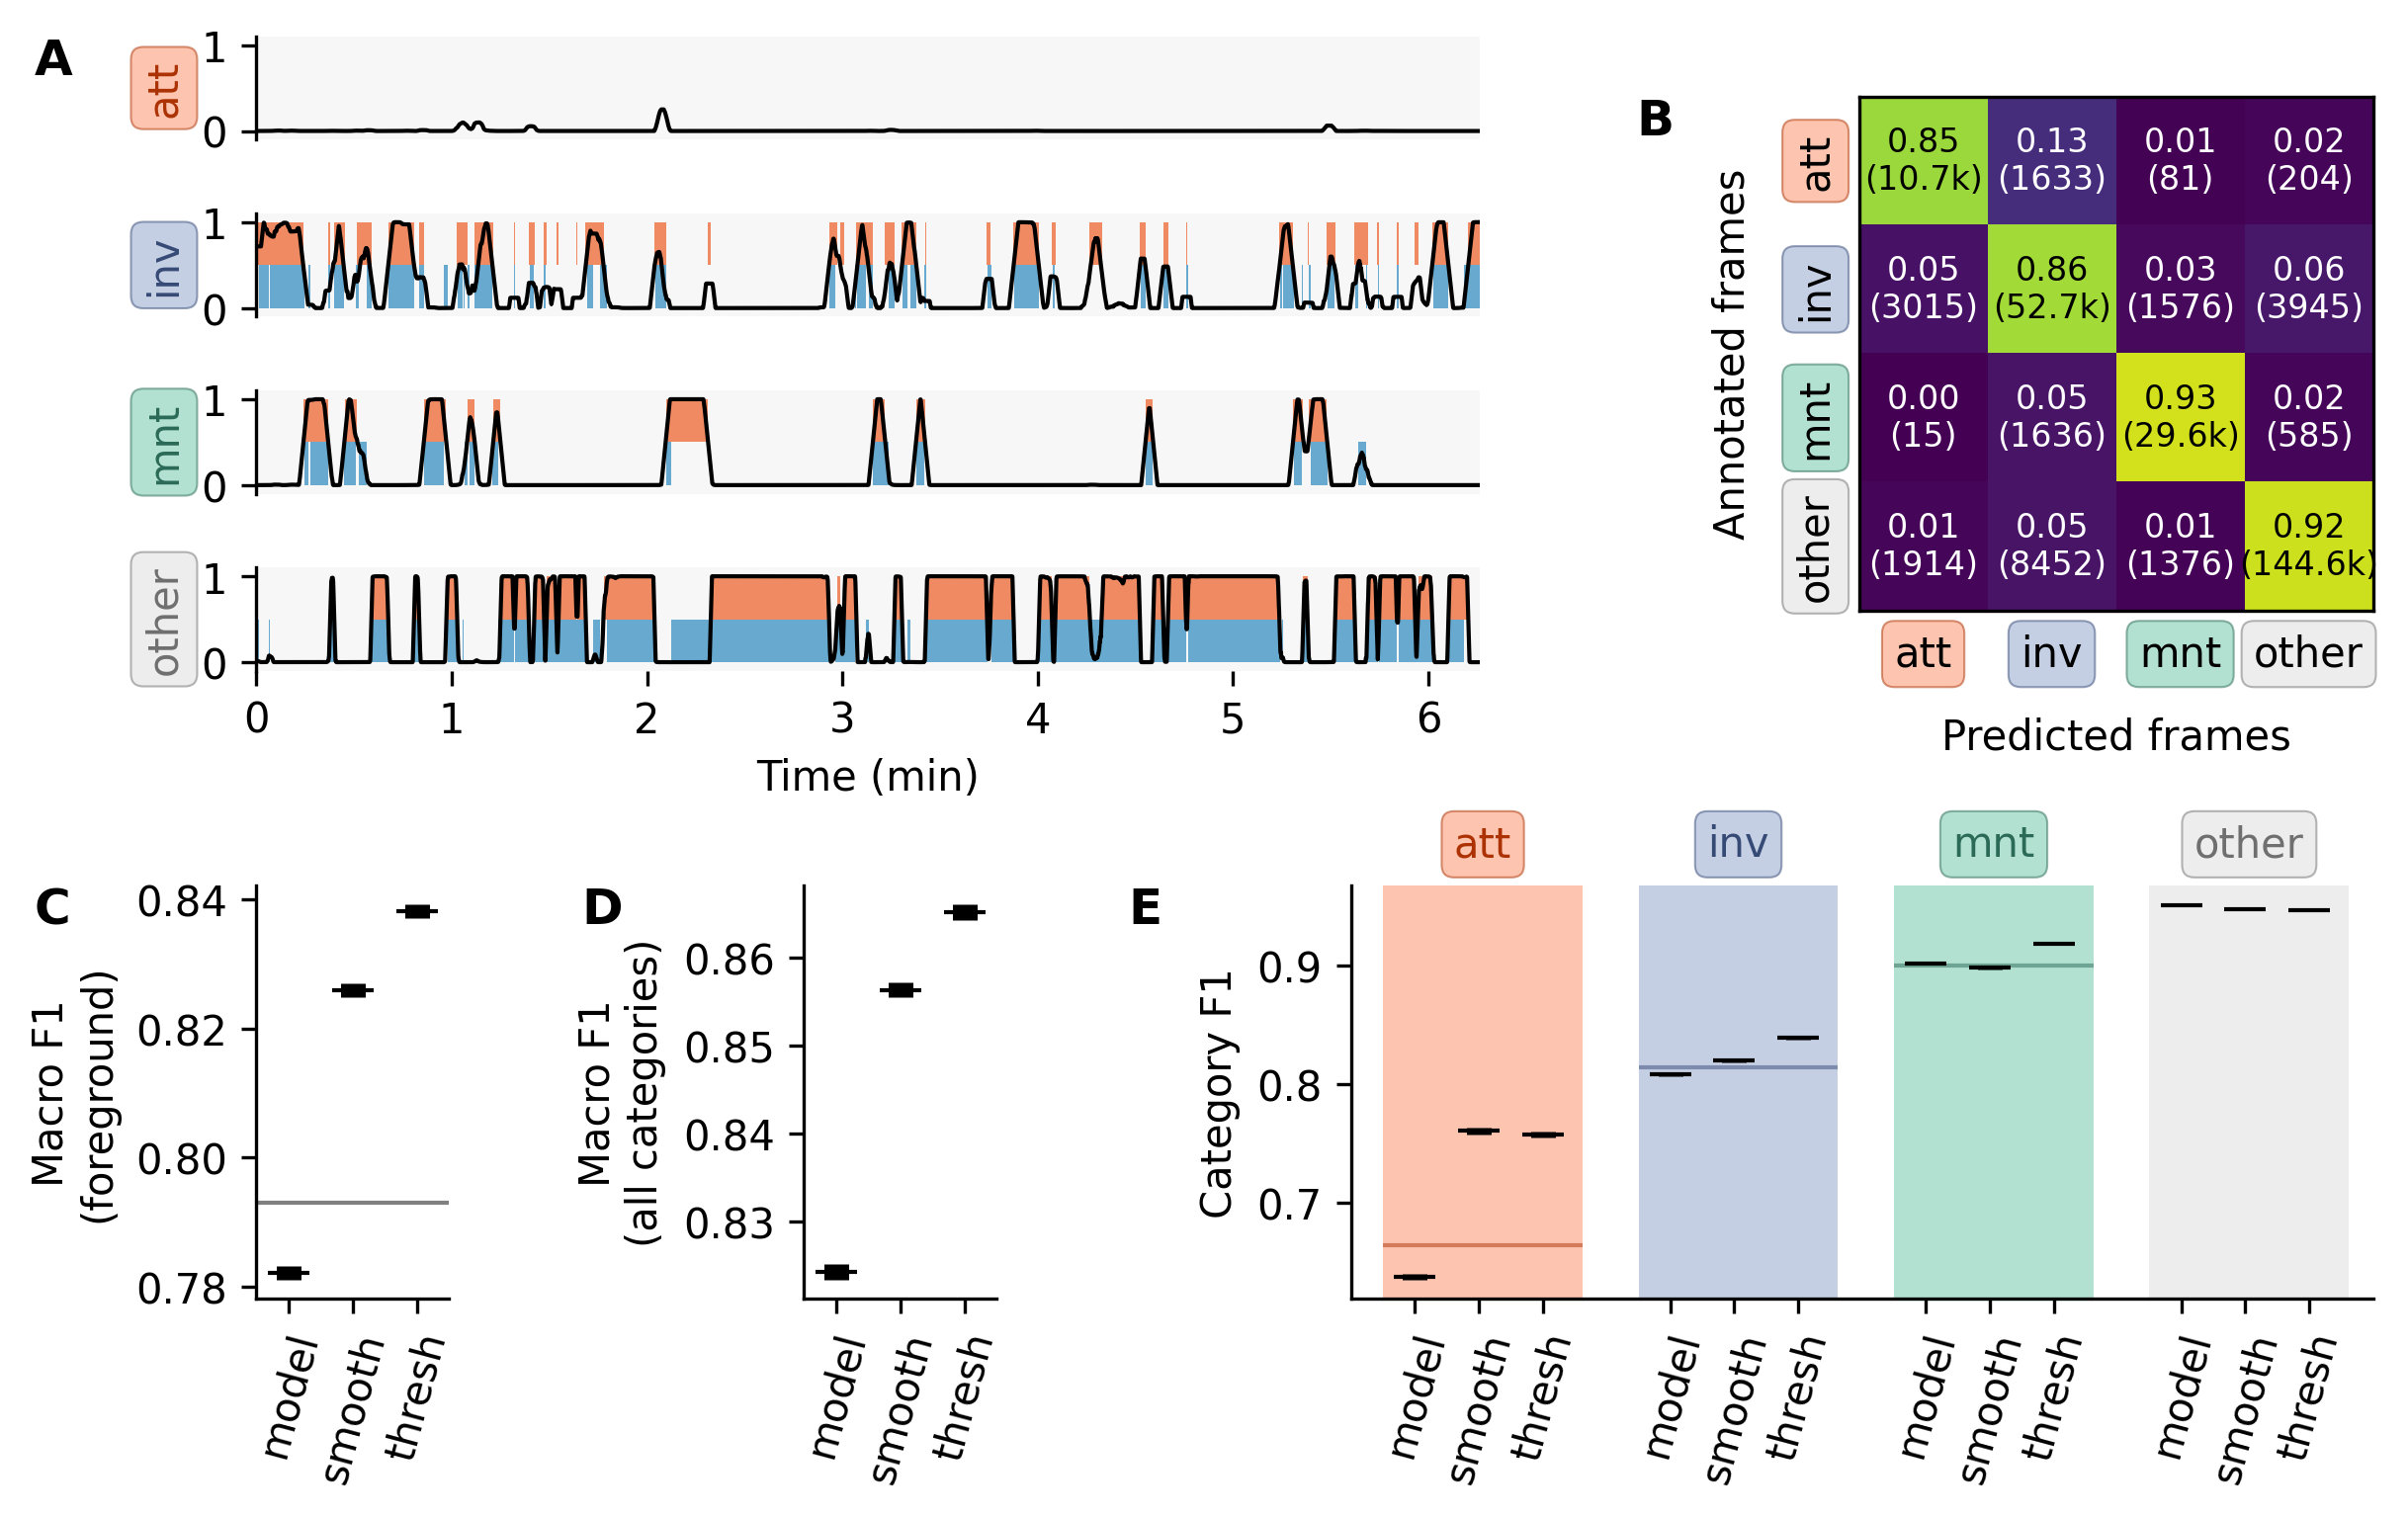

In [317]:
scores = aggregate_scores(summary, "timestamp_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

fig = plt.figure(layout="constrained", figsize=(8, 5), dpi=150)
gs = plt.GridSpec(5, 4, figure=fig, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1.5, 1.5, 1, 4])

axes_timeline = [fig.add_subplot(gs[idx, :3]) for idx in range(num_categories)]
ax_confusion = fig.add_subplot(gs[:-1, 3])
ax_macro_foreground = fig.add_subplot(gs[-1, 0])
ax_macro_all = fig.add_subplot(gs[-1, 1])
ax_categories = fig.add_subplot(gs[-1, 2:])

ax_macro_foreground.axhline(y=0.793, lw=1, c="grey")
plot_errorbars(
    ax_macro_foreground,
    *scores["macro-foreground"].to_numpy().T,
    ylabel="Macro F1\n(foreground)",
)
plot_errorbars(
    ax_macro_all,
    *scores["macro-all"].to_numpy().T,
    ylabel="Macro F1\n(all categories)",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
plot_errorbars(
    ax_categories,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="Category F1",
)
for (idx, category), color, baseline in zip(enumerate(category_labels), colors, [0.664, 0.814, 0.900, None]):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_categories.axvspan(x_left, x_right, color=color, alpha=0.5, lw=0)
    if baseline is not None:
        ax_categories.hlines(
            baseline, x_left, x_right, lw=1, alpha=0.5, color=adjust_lightness(color, 0.5), capstyle="butt"
        )
    ax_categories.text(
        (x_left + x_right) / 2,
        1.05,
        category,
        ha="center",
        va="bottom",
        **get_label_kwargs(color),
        transform=transforms.blended_transform_factory(ax_categories.transData, ax_categories.transAxes),
    )

for ax in [ax_macro_foreground, ax_macro_all, ax_categories]:
    ax.spines[["right", "top"]].set_visible(False)


dyad_results = test_result.classification_results[18].classification_results[("resident", "intruder")]
plot_classification_timeline(
    dyad_results.predictions,
    dyad_results.categories,
    annotations=dyad_results.annotations,
    timestamps=dyad_results.timestamps,
    y_proba_smoothed=dyad_results.y_proba_smoothed,
    interval=(-np.inf, np.inf),
    x_tick_step=30 * 60,
    x_tick_conversion=lambda ticks: (np.asarray(ticks) / (30 * 60)).astype(int),
    category_labels=category_labels,
    axes=axes_timeline,
)

for ax, color in zip(axes_timeline, colors):
    ax.set_ylabel(ax.get_ylabel(), rotation=90, va="bottom", **get_label_kwargs(color))
ax.set_xlabel("Time (min)")


plot_confusion_matrix(
    [y["true"]["timestamp"] for y in confusion],
    [y["pred"]["timestamp"] for y in confusion],
    ax=ax_confusion,
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(ax_confusion.get_xticklabels(), colors):
    label.set_bbox(get_label_kwargs(color)["bbox"])
for label, color in zip(ax_confusion.get_yticklabels(), colors):
    label.set_bbox(get_label_kwargs(color)["bbox"])

ax_confusion.tick_params(axis="both", which="major", pad=2, width=0)
ax_confusion.set_ylabel("Annotated frames", labelpad=10)
ax_confusion.set_xlabel("Predicted frames", labelpad=10)

for ax, label in zip(
    [axes_timeline[0], ax_confusion, ax_macro_foreground, ax_macro_all, ax_categories],
    ["A", "B", "C", "D", "E"],
):
    transform = ax.transAxes + transforms.ScaledTranslation(-0.75, 0, fig.dpi_scale_trans)
    fig.text(0, 1, label, transform=transform, fontsize=12, va="top", weight="semibold")

plt.show()

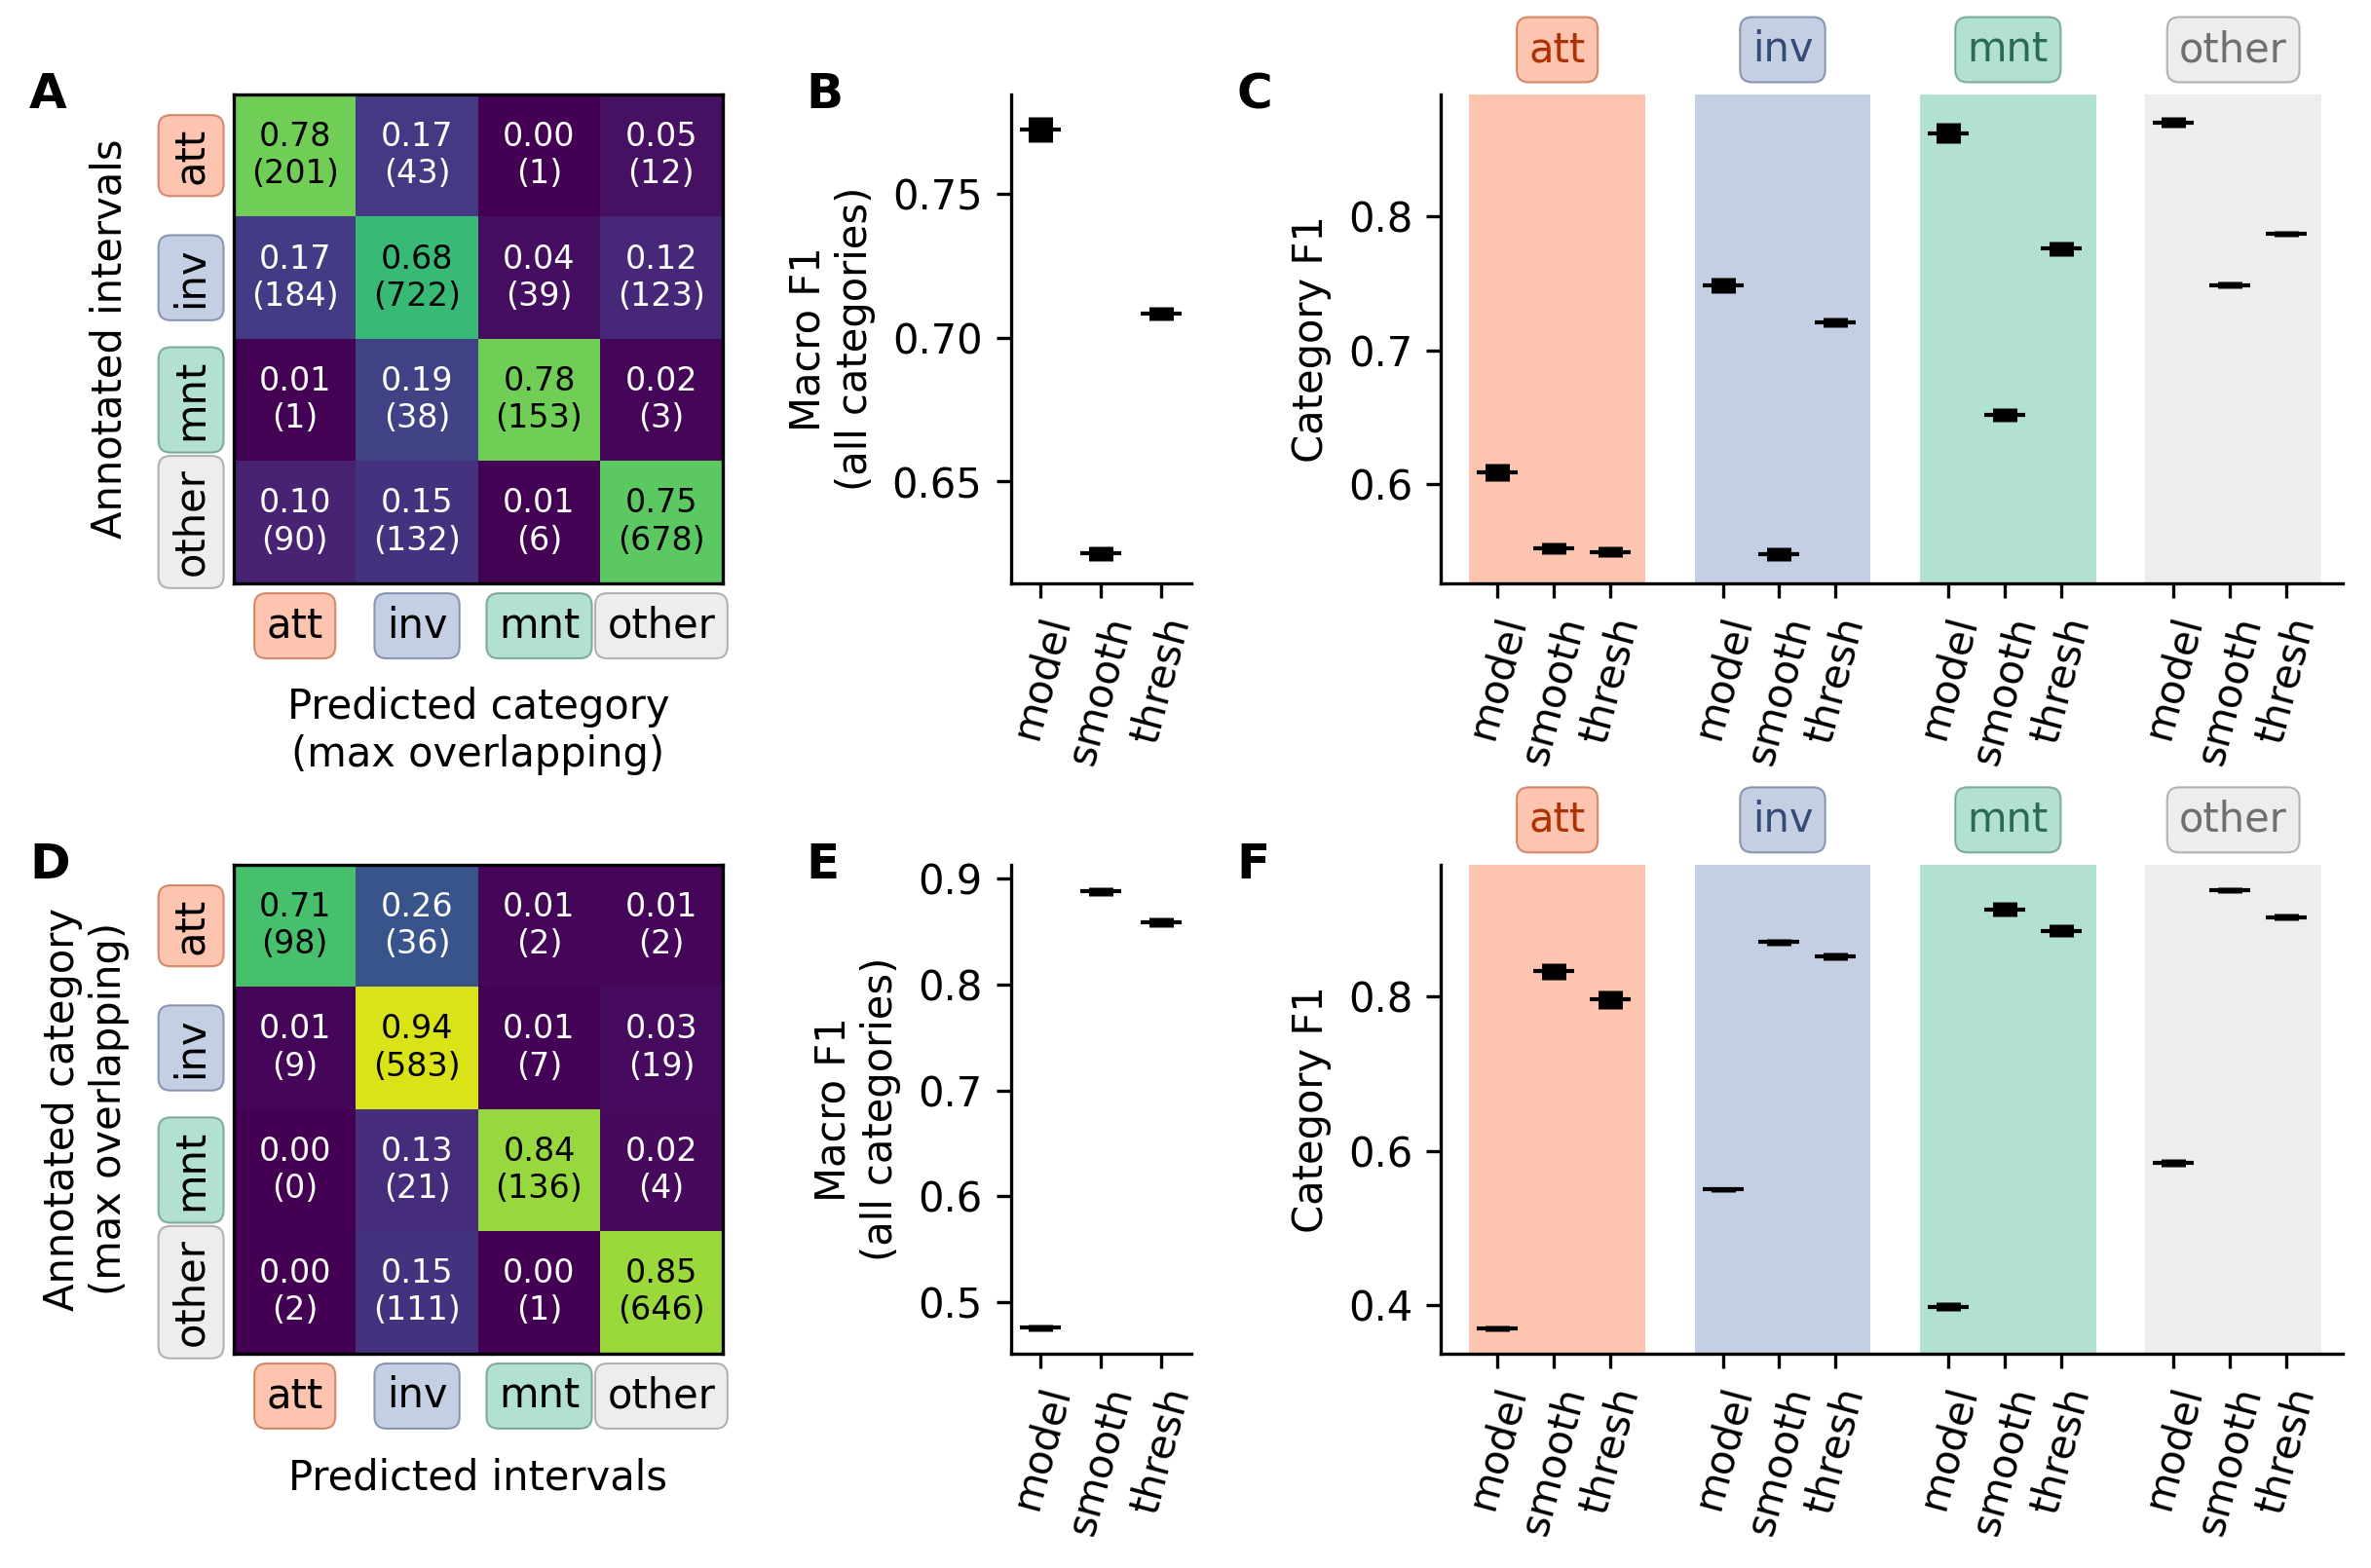

In [318]:
fig, axes = plt.subplots(2, 3, layout="constrained", figsize=(8, 5.25), dpi=150, width_ratios=[3, 1, 5])

# on annotation interval level

plot_confusion_matrix(
    [y["true"]["annotation"] for y in confusion],
    [y["pred"]["annotation"] for y in confusion],
    ax=axes[0, 0],
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(axes[0, 0].get_xticklabels(), colors):
    label.set_bbox(get_label_kwargs(color)["bbox"])
for label, color in zip(axes[0, 0].get_yticklabels(), colors):
    label.set_bbox(get_label_kwargs(color)["bbox"])
axes[0, 0].tick_params(axis="both", which="major", pad=2, width=0)
axes[0, 0].set_ylabel("Annotated intervals", labelpad=10)
axes[0, 0].set_xlabel("Predicted category\n(max overlapping)", labelpad=10)

scores = aggregate_scores(summary, "annotation_f1", categories=dataset_test.categories)
plot_errorbars(axes[0, 1], *scores["macro-all"].to_numpy().T, ylabel="Macro F1\n(all categories)")

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
plot_errorbars(
    axes[0, 2],
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="Category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    axes[0, 2].axvspan(x_left, x_right, color=color, alpha=0.5, lw=0)
    axes[0, 2].text(
        (x_left + x_right) / 2,
        1.05,
        category,
        ha="center",
        va="bottom",
        **get_label_kwargs(color),
        transform=transforms.blended_transform_factory(axes[0, 2].transData, axes[0, 2].transAxes),
    )


# on prediction interval level

plot_confusion_matrix(
    np.array([y["true"]["prediction"] for y in confusion], dtype=object),
    np.array([y["pred"]["prediction"] for y in confusion], dtype=object),
    ax=axes[1, 0],
    category_labels=category_labels,
    show_colorbar=False,
)
labels = []
for label, color in zip(axes[1, 0].get_xticklabels(), colors):
    label.set_bbox(get_label_kwargs(color)["bbox"])
for label, color in zip(axes[1, 0].get_yticklabels(), colors):
    label.set_bbox(get_label_kwargs(color)["bbox"])
axes[1, 0].tick_params(axis="both", which="major", pad=2, width=0)
axes[1, 0].set_ylabel("Annotated category\n(max overlapping)", labelpad=10)
axes[1, 0].set_xlabel("Predicted intervals", labelpad=10)

scores = aggregate_scores(summary, "prediction_f1", categories=dataset_test.categories)
plot_errorbars(axes[1, 1], *scores["macro-all"].to_numpy().T, ylabel="Macro F1\n(all categories)")

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
plot_errorbars(
    axes[1, 2],
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="Category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    axes[1, 2].axvspan(x_left, x_right, color=color, alpha=0.5, lw=0)
    axes[1, 2].text(
        (x_left + x_right) / 2,
        1.05,
        category,
        ha="center",
        va="bottom",
        **get_label_kwargs(color),
        transform=transforms.blended_transform_factory(axes[1, 2].transData, axes[1, 2].transAxes),
    )

for ax in [axes[0, 1], axes[0, 2], axes[1, 1], axes[1, 2]]:
    ax.spines[["right", "top"]].set_visible(False)

for ax, label in zip(axes.ravel(), ["A", "B", "C", "D", "E", "F"]):
    transform = ax.transAxes + transforms.ScaledTranslation(-0.7, 0, fig.dpi_scale_trans)
    ax.text(0, 1, label, transform=transform, fontsize=12, va="center", weight="semibold")

fig.get_layout_engine().set(wspace=0.05)

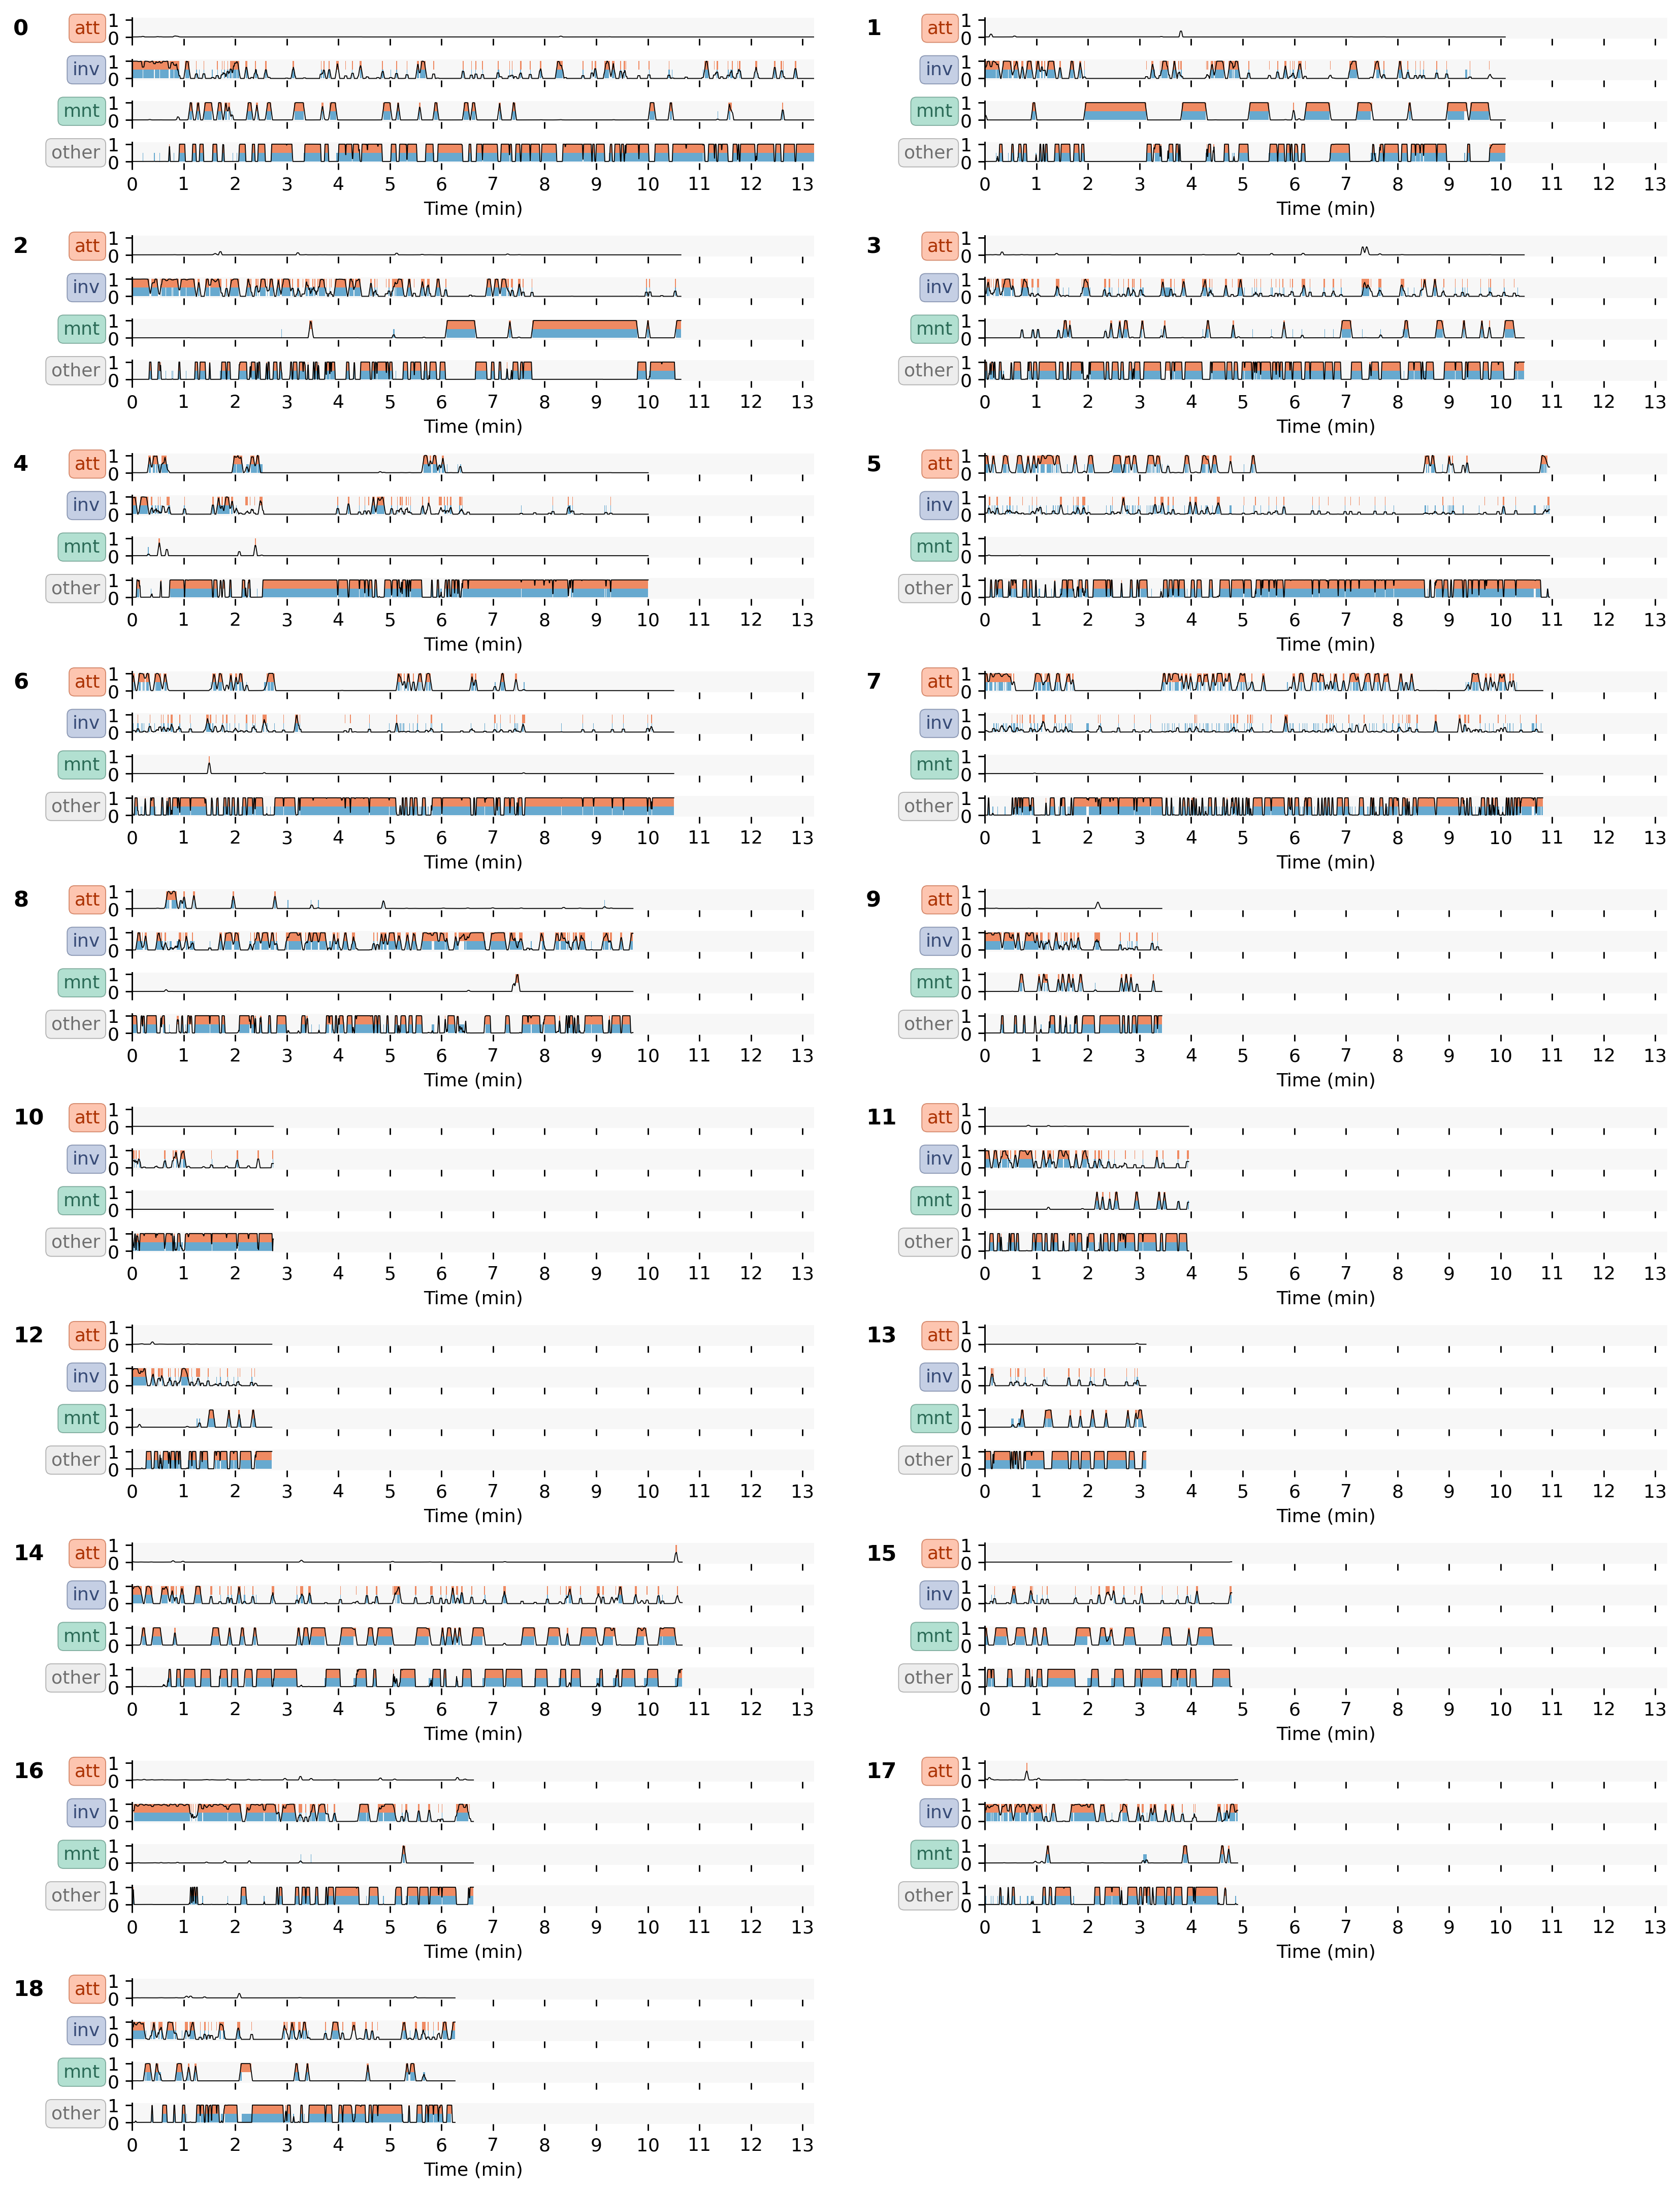

In [319]:
num_sequences = 19
interval = (0, test_result.predictions["stop"].max())

fig = plt.figure(figsize=(15, 40), dpi=130)
gs = plt.GridSpec(num_sequences, 2, figure=fig, hspace=0.5, wspace=0.25)

for sequence_idx in range(19):
    gs_inner = gridspec.GridSpecFromSubplotSpec(
        num_categories,
        1,
        subplot_spec=gs[sequence_idx // 2, sequence_idx % 2],
        hspace=1,
    )
    axes = gs_inner.subplots(sharex=True)

    dyad_results = test_result.classification_results[sequence_idx].classification_results[("resident", "intruder")]
    plot_classification_timeline(
        dyad_results.predictions,
        dyad_results.categories,
        annotations=dyad_results.annotations,
        timestamps=dyad_results.timestamps,
        y_proba_smoothed=dyad_results.y_proba_smoothed,
        interval=(-np.inf, np.inf),
        category_labels=category_labels,
        axes=axes,
    )
    axes[-1].set_xlim(interval)
    x_ticks = np.arange(*interval, 30 * 60)
    axes[-1].set_xticks(x_ticks)
    axes[-1].set_xticklabels(np.arange(x_ticks.size, dtype=int))
    axes[-1].set_xlabel("Time (min)")

    for ax, color in zip(axes, colors):
        ax.set_ylabel(
            ax.get_ylabel(),
            va="center",
            ha="right",
            **get_label_kwargs(color),
        )
        for line in ax.get_lines():
            line.set_linewidth(0.5)

    fig.text(
        0,
        1,
        f"{sequence_idx}",
        transform=(axes[0].transAxes + transforms.ScaledTranslation(-0.9, 0, fig.dpi_scale_trans)),
        fontsize=12,
        va="top",
        weight="semibold",
    )

plt.show()